# TRAM analysis of ion binding kinetics (1d)
we do WHAM/TRAM estimates in one dimension with errors of the free-energy

please log significant changes and todos here:
* todo: add TRAM in `my_estimate` class
* todo (low priority): preparing the data for tram talke quite a bit when many trajs/many microstates are used if would be more efficient to do it only once and boostrap that data, rather than the way it's done now

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# General Libraries
import sys, os, shutil
from glob import glob

import pickle
from copy import deepcopy
import numpy as np
import scipy
import pandas as pd
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import pyemma

In [3]:
## set directories

MORstate='active'
dir = "/sc/orga/projects/filizm02a/work/ion_MOR/"+MORstate
dir_US = dir + '/umbrella_sampling/'
dir_US_cv = dir_US + '/cv_z_Nwater/'

dir_MD = dir + '/unbiased_sampling/'
dir_MD_cv = dir_MD + '/cv_z_Nwater/'


## read data

In [4]:
## how long are the trajectories?
## with no striding, 1 frame = 2 ps 
timestep = 2./1000 # in ns

### read data from the US collective variable files

In [5]:
## read biased data and keep only the z-variable

## rather than glob, we construct the list manually 
## so that we have the proper order 
US_traj_list = [dir_US_cv+u'/um_both-%d.dat'%i for i in range(159)]

if not len(US_traj_list)==len(glob(dir_US_cv+u'/um_both-*.dat')):
    print(len(glob(dir_US_cv+u'/um_both-*.dat')))
    raise Exception

# read, and calc length of trajs
US_traj=[np.loadtxt(file)[:,0] for file in US_traj_list]
US_len = np.array([trj.shape[0] for trj in US_traj])
print("Read %d traj for US runs"%len(US_traj))

meta_info = np.loadtxt(dir_US_cv+'meta2.dat')
centers = np.array(meta_info[:,1])

Read 159 traj for US runs


### read data from the US collective variable files

In [6]:
MD_traj_list = [dir_MD_cv+u'/md_both-%d.dat'%i for i in range(159)]

if not len(MD_traj_list)==len(glob(dir_MD_cv+u'/md_both-*.dat')):
    print(len(glob(dir_US_cv+u'/md_both-*.dat')))
    raise Exception
    
# read, and calc length of trajs
MD_traj=[np.loadtxt(file)[:,0] for file in MD_traj_list]
MD_len = np.array([trj.shape[0] for trj in MD_traj])
print("Read %d traj for US runs"%len(MD_traj))


Read 159 traj for US runs


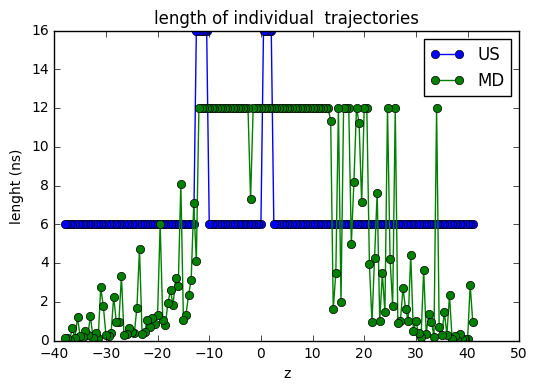

In [7]:
plt.plot(centers,timestep*US_len,'-o',label='US')
plt.plot(centers,timestep*MD_len,'-o',label='MD')
plt.legend()
plt.title("length of individual  trajectories")
plt.xlabel('z')
plt.ylabel('lenght (ns)')
plt.show()

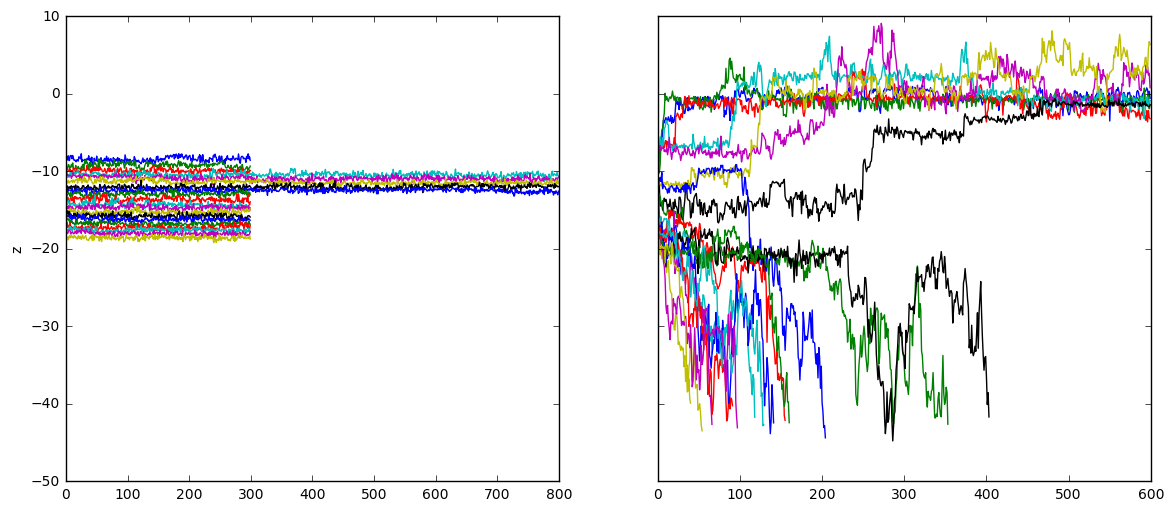

In [8]:
## inspect trajectories
subset = slice(100,120)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
axes[0].set_ylabel('z')

for traj in US_traj[subset]:
    axes[0].plot(traj[0::10])
for traj in MD_traj[subset]:
    axes[1].plot(traj[0::10])
plt.show()

##  Estimation (no bootstrap)

### define classes
We use this scheme: discretization $\rightarrow$ (bootstrap) $\rightarrow$  estimate, where estimate can be MSM (only MD), WHAM (only US/or both), TRAM (both)

In [9]:
class discretization(object):
    """
    Utility class to experiment with different discretizations
    Supply trajs and the number of bins. 
    A buffer is addes intra and extra-cellular bulk
    
    Contains:
        trajs refs to the original trajs
        dtrajs the discretized trajs
        centers the microstate centers
        US_set, MD_set the slices of the two sets
        meta_info the information about centers and elastic
        nbins the number of bins
    """
    def __init__(self, US_traj , MD_traj, meta_info, nbins):
        ## stores the centers and ks of the US
        self.us_centers = list(meta_info[:,1])
        self.us_force_constants = list(meta_info[:,2])
        
        ## bins
        dx = (np.max(centers) - np.min(centers))/nbins
        self.dx = dx
        buffer = 5 # 5 angstrom
        centers0 = np.linspace(np.min(centers)-buffer,np.max(centers)+buffer,nbins)
        self.centers = centers0.reshape((nbins,1))
        
        ## preps the trajectories and does the discretization
        self.trajs = US_traj + MD_traj
        self.US_set = slice(0,len(US_traj))
        self.MD_set = slice(len(US_traj),len(self.trajs))
        
        self.dtrajs = pyemma.coordinates.assign_to_centers(
            data=self.trajs, centers=self.centers)
        


In [122]:
class my_estimate(object):
    """
    utility calss for estimation of a given discretizaton
    first sets up the data for the estimator to be called, then calls it
    """
    def __init__(self,  discr, estimator='wham', lag=1, stride=1, verbose=False):
        ## sets up the pieces from the disctretization and the US information
        
        ## we hard copy the trajs otherwise the C-call is not working...
        self.us_trajs= [np.copy(t[::stride]) for t in discr.trajs[discr.US_set]]
        self.us_dtrajs = [np.copy(t[::stride]) for t in  discr.dtrajs[discr.US_set]]
        
        n_US = len(self.us_trajs)
        self.us_centers = discr.us_centers
        self.us_force_constants = discr.us_force_constants
        self.md_trajs = [np.copy(t[::stride]) for t in  discr.trajs[discr.MD_set]]
        self.md_dtrajs= [np.copy(t[::stride]) for t in  discr.dtrajs[discr.MD_set]]

        if verbose:
            tot_US_len = np.array([len(t) for t in self.us_dtrajs]).sum()
            tot_MD_len = np.array([len(t) for t in self.md_dtrajs]).sum()
            print("This discretization has:\n" + 
                  "  %d US traj (tot %d frames)\n" % (len(self.us_dtrajs), tot_US_len) +
                  "  %d MD traj (tot %d frames)\n" % (len(self.md_dtrajs), tot_MD_len))
        
        self.stride=stride

        
        if estimator=='wham':
            print("Running WHAM... ignoring unbiased (check)")
            self.wham = pyemma.thermo.estimate_umbrella_sampling(
                self.us_trajs, 
                self.us_dtrajs, 
                self.us_centers, 
                self.us_force_constants, 
                md_trajs=None, 
                md_dtrajs=None, 
                kT=0.61,  ## at 310 K
                maxiter=10000, maxerr=1e-6, 
                save_convergence_info=0, estimator='wham', 
                dt_traj='1 step', init=None, 
                init_maxiter=10000, init_maxerr=1e-06, width=None)
        elif estimator=='tram':
            ## keep this separate for now, but no need to, can be merged with the previouse
            print("Running TRAM with lag %d... "%(lag))
            self.tram = pyemma.thermo.estimate_umbrella_sampling(
                self.us_trajs, 
                self.us_dtrajs, 
                self.us_centers, 
                self.us_force_constants, 
                md_trajs=self.md_trajs, 
                md_dtrajs=self.md_dtrajs, 
                kT=0.61,  ## at 310 K
                maxiter=10000, maxerr=1e-6, 
                save_convergence_info=0, estimator='tram', 
                lag=lag, dt_traj='1 step', init=None, 
                init_maxiter=10000, init_maxerr=1e-06, width=None)
        else:
            print("unknown estimator")
            raise Exception

### single point estimation (WHAM)

* @Yibo check the bin and stride I'm using big strides and large bins here for speed, these don't have to be the final values
* also, check max_iter and error limits in the `my_estimate` class

In [11]:
## do a single point estimation for given bins, and stride
d1 = discretization(US_traj , MD_traj=[], meta_info=meta_info, nbins=100)
e1 = my_estimate(d1,estimator='wham', stride=100, verbose=True)

This discretization has:
  159 US traj (tot 5220 frames)
  0 MD traj (tot 0 frames)

Running WHAM. ignoring unbiased (check)


/sc/orga/projects/filizm02a/general/software/anaconda/miniconda2/envs/dimerization_project/lib/python2.7/site-packages/pyemma/thermo/estimators/WHAM_estimator.py:159: NotConvergedWarning: WHAM did not converge: last increment = 9.52092e-05
  self, 'WHAM', self.maxiter, self.maxerr))


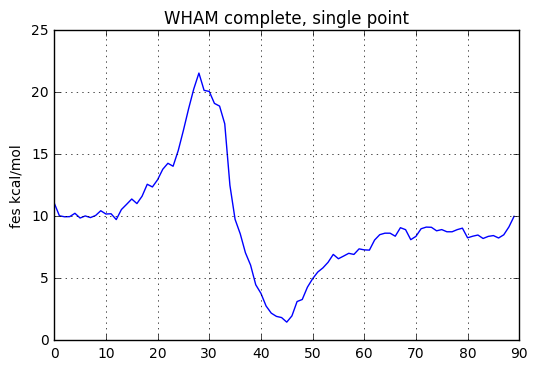

In [12]:
plt.plot(e1.wham.free_energies)
plt.title("WHAM complete, single point")
plt.ylabel("fes kcal/mol")
plt.grid()
plt.show()

### single point WHAM parameter seacrh
try three different discretizations and different strides

In [ ]:
## NOT RUN
## bookkeeping is totally missing here, don't run before fixing

bin_list = [100,200,500]
stride_list = [10,20,100]
for nbins in bin_list:
    d = discretization(US_traj , MD_traj, meta_info=meta_info, nbins)
    for stride in stride_list:
        e = my_estimate(d,estimator='wham', stride=stride)


###  single point estimation (TRAM)

In [ ]:
## do a single point estimation for given bins, and stride
d1 = discretization(US_traj , MD_traj, meta_info=meta_info, nbins=100)
e1 = my_estimate(d1,estimator='tram', lag=1, stride=100, verbose=True)

This discretization has:
  159 US traj (tot 5220 frames)
  159 MD traj (tot 4629 frames)

Running TRAM with lag 1... 


In [ ]:
plt.plot(e1.wham.free_energies)
plt.title("WHAM complete, single point")
plt.ylabel("fes kcal/mol")
plt.grid()
plt.show()

## Estimation (bootstrap)

### define class
add exception raising, check for fraction 1 and patho cases

In [15]:
def get_chunk(traj, fraction_length ,verbose=False):
    """
    randomly subsets a traj
    """
    totlen = traj.shape[0]
    length = int(fraction_length*totlen)
    start = np.random.randint(low=0,high= totlen - length)
    if verbose:
        print(start)
    return slice(start,(start+length))
    

class bootstrap(discretization):
    """
    creates one bootstrap discretization sample from a given discretization
    extracting from each traj n_from_each trajs with a fraction of the length
    """
    def __init__(self, fulldata , n_from_each=1, fraction_length=1.):

        #print(n_from_each)
        US_traj=fulldata.trajs[fulldata.US_set]
        MD_traj=fulldata.trajs[fulldata.MD_set]
        US_dtraj=fulldata.dtrajs[fulldata.US_set]
        MD_dtraj=fulldata.dtrajs[fulldata.MD_set]

        ## bootstraps the US trajs
        US_slices=[]
        self.us_centers = []
        self.us_force_constants = []
        sample_US_traj = []
        sample_US_dtraj = []
        for j in range(n_from_each):
            for i,t in enumerate(US_traj):
                sli = get_chunk(t, fraction_length)
                sample_US_traj.append(np.copy(t[sli]))
                sample_US_dtraj.append(np.copy((US_dtraj[i])[sli]))
                (self.us_centers).append(np.copy(meta_info[i,1]))
                (self.us_force_constants).append(np.copy(meta_info[i,2]))
        
        ## bootstraps the MD trajs
        MD_slices = []
        sample_MD_traj = []
        sample_MD_dtraj = []
        for j in range(n_from_each):
            for i,t in enumerate(MD_traj):
                sli = get_chunk(t, fraction_length)
                sample_MD_traj.append(np.copy(t[sli]))
                sample_MD_dtraj.append(np.copy((MD_dtraj[i])[sli]))
        
        self.trajs = sample_US_traj + sample_MD_traj
        self.dtrajs = sample_US_dtraj + sample_MD_dtraj
        
        ## bins
        self.dx = fulldata.dx
        self.centers = fulldata.centers
        ## preps the trajectories and does the discretization
        self.US_set = slice(0,len(sample_US_traj))
        self.MD_set = slice(len(sample_US_traj),len(self.trajs))
        

### estimate WHAM with bootstrap 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
## define one discretization to bootstrap from 
d1 = discretization(US_traj , MD_traj=[], meta_info=meta_info, nbins=100)

n_samples=10
bstrp = []
for k in range(n_samples):
    b = bootstrap(d1,n_from_each=10,fraction_length=.1)
    bstrp.append( my_estimate(b,estimator='wham', stride=100) )

Running WHAM. ignoring unbiased (check)
Running WHAM. ignoring unbiased (check)
Running WHAM. ignoring unbiased (check)
Running WHAM. ignoring unbiased (check)
Running WHAM. ignoring unbiased (check)
Running WHAM. ignoring unbiased (check)
Running WHAM. ignoring unbiased (check)
Running WHAM. ignoring unbiased (check)
Running WHAM. ignoring unbiased (check)
Running WHAM. ignoring unbiased (check)


In [112]:
def get_sample_conf(bstrp, discr):
    """
    get confidence intervals and average
    """
    nsamples = len(bstrp)
    nmicrostates = discr.centers.shape[0]
    ene = np.zeros(shape=(nmicrostates,nsamples))
    ene.fill(np.nan)    
    x=d1.centers.reshape((d1.centers.shape[0]))
    
    for i in range(nsamples):
        w = bstrp[i].wham
        ene[w.active_set,i]=w.free_energies

    ave = np.mean(ene,axis=1)
    lconf = np.percentile(ene,10,axis=1)
    uconf = np.percentile(ene,90,axis=1)
    return (ene,x,ave,lconf,uconf)
    #return ene

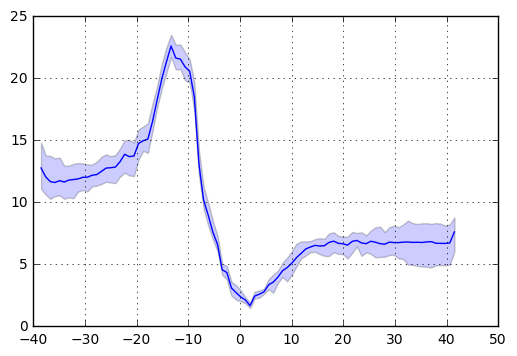

In [118]:
ene,x,ave,lconf,uconf=get_sample_conf(bstrp,d1)

#for i in range(10):
#    plt.plot(x,ene[:,i],color='gray')
plt.plot(x,ave)
plt.fill_between(x,uconf,lconf,alpha=.2)
plt.grid()
plt.show()

### bootstrap TRAM